# 支持向量机

## 一、关键库说明
- **`numpy`**: 数值计算基础库
  
- **`pandas`**: 数据处理与分析

- **`matplotlib`**: 数据可视化（中文字体设置为'SimHei'）

- **`seaborn`**: 统计数据可视化库

- **`scikit-learn`**: 机器学习核心库
    - `svm`: 支持向量机实现
  
    - `StandardScaler`: 数据标准化
 
    - `train_test_split`: 数据集分割
 
    - `GridSearchCV`: 超参数网格搜索
 
    - `metrics`：分类报告/准确率/混淆矩阵/ROC曲线
- **自定义工具**：`utils.py`包含加载数据、绘制ROC曲线等功能

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

import seaborn as sns
from utils import *
plt.rcParams['font.family'] = 'SimHei'

## 二、数据读取并部分可视化
- 从.csv文件中读取数据
- 分成训练集图像、训练集标签、测试集图像、测试集标签四个部分
- 展示训练集与测试集前25张图片

In [2]:
# 加载数据
train = pd.read_csv("./dataset/fashion-mnist_train.csv")
test = pd.read_csv("./dataset/fashion-mnist_test.csv") 
(train_images, train_labels), (test_images, test_labels) = load_data(train,test)

In [3]:
class_names = [' T恤', '裤子', '套衫', '连衣裙', '外套','凉鞋', '衬衫', '运动鞋', '包', '踝靴']

In [4]:
train = train_images.reshape(-1, 28, 28)
test = test_images.reshape(-1, 28, 28)

- ### 训练集前25张图片

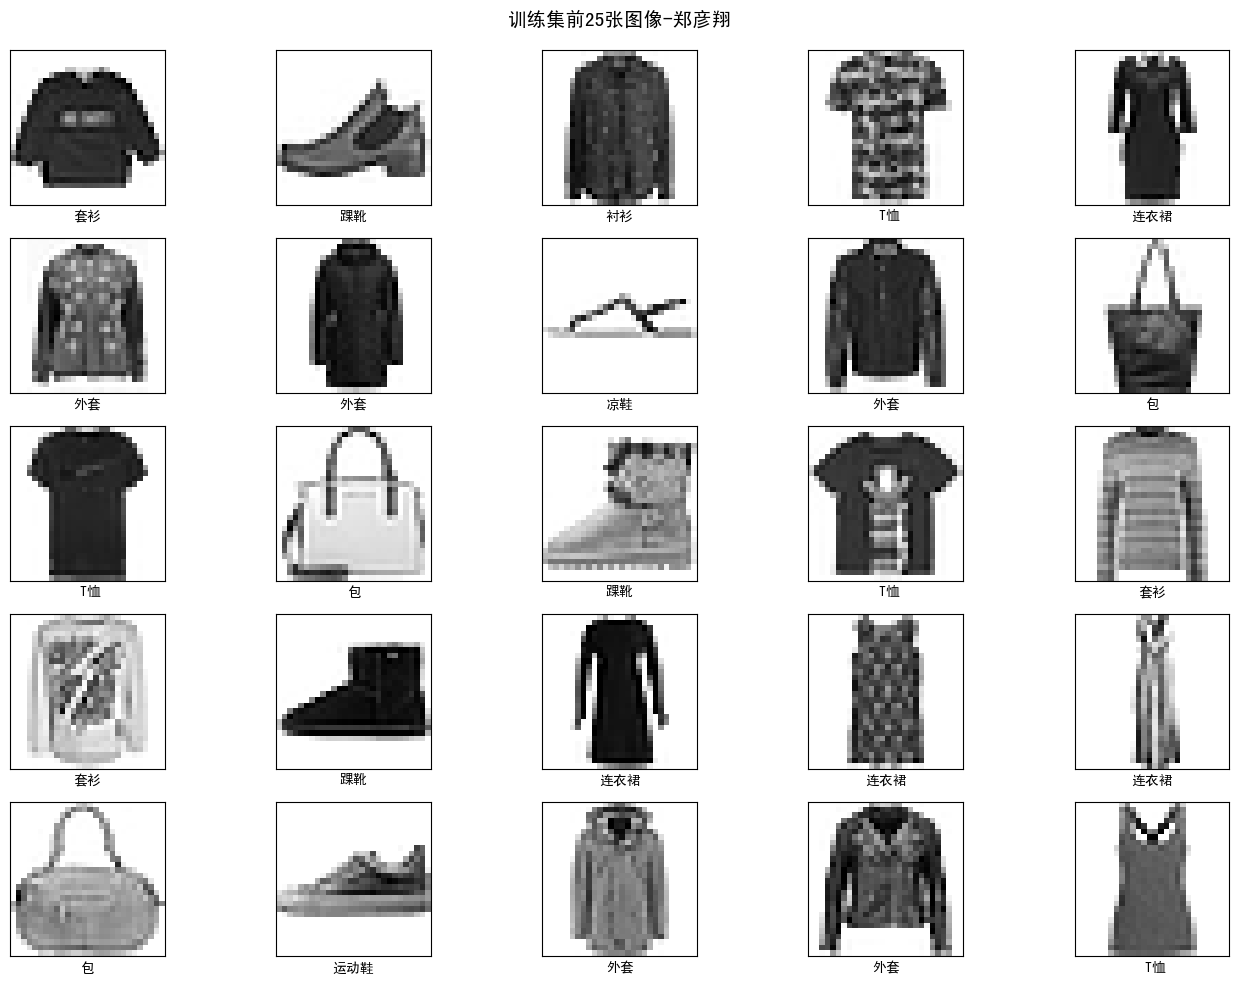

In [5]:
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(14,10))
plt.suptitle("训练集前25张图像-郑彦翔", fontsize=14)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

- ### 测试集前25张图片

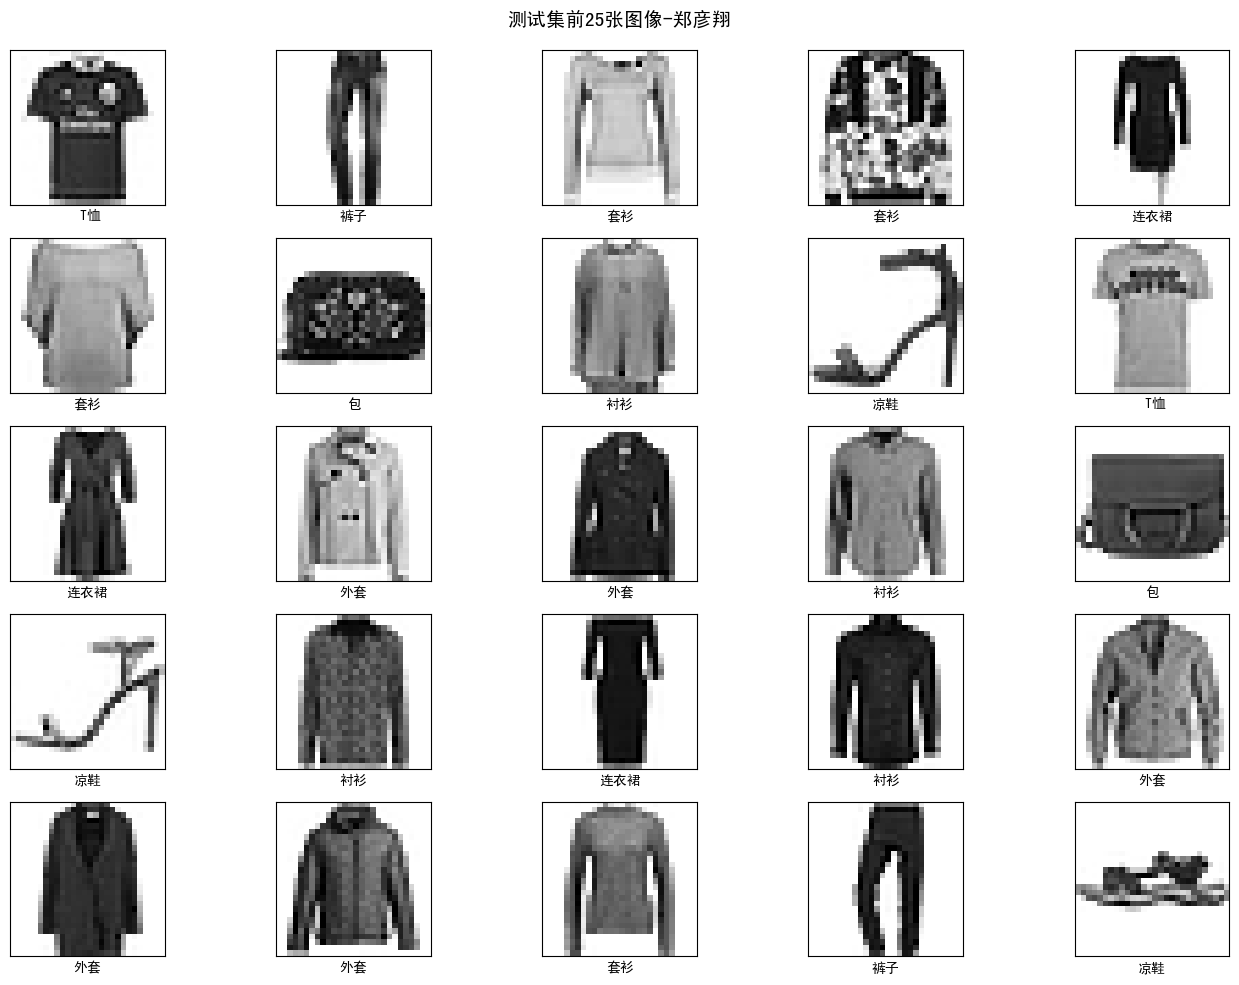

In [6]:
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(14,10))
plt.suptitle("测试集前25张图像-郑彦翔", fontsize=14)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[test_labels[i]])
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

- ### 数据处理
  - 对像素值进行归一化处理
  - 划分子集，加快训练速度
  - 数据标准化，提升SVM收敛速度与精度

In [7]:
train_images = train_images / 255.0  # normalize pixel values
test_images = test_images / 255.0

In [8]:
train_images_sub, _, train_labels_sub, _ = train_test_split(train_images, train_labels, train_size=15000, 
                                                            stratify=train_labels, random_state=42)
test_images_sub, _, test_labels_sub, _ = train_test_split(test_images, test_labels, train_size=2500, 
                                                          stratify=test_labels, random_state=42)

In [9]:
scaler = StandardScaler()
train_images_sub= scaler.fit_transform(train_images_sub)
test_images_sub= scaler.transform(test_images_sub)

## 三、支持向量机（SVM）模型构建
### 核心机制：  
- **超平面优化**：求解 $w^Tx + b = 0$ 使间隔 $\frac{2}{\|w\|}$ 最大化。  
- **核函数选择**：

  - 线性核：$K(x_i,x_j) = x_i^Tx_j$（高效处理高维特征）
    
  - 多项式核：$K(x_i,x_j) = (x_i^T x_j + c)^d$，通过阶数$d$控制非线性程度，适合中等复杂度非线性问题
 
    
  - RBF核：$K(x_i,x_j) = \exp(-\gamma \|x_i - x_j\|^2)$（捕捉非线性模式）

- **正则化**：参数 `C` 平衡分类误差与模型复杂度。  

### 多核SVM实现与调优  
- 核心参数解释
| **参数** | **物理意义** |**Fashion-MNIST调优策略** | **理论依据** |
|----------|--------------|---------------------------|--------------|
| `C` | 误分类惩罚系数 |  对数空间搜索 $[10^{-2}, 10^2]$ | 结构风险最小化 |
| `degree` | 多项式阶数 | 优选2-3阶，避免≥4阶 | VC维控制 |
| `gamma` | RBF核宽度 | 优先`'scale'`，次选$10^{-3}$量级 | 特征方差适配 |

- 由于数据集庞大且设备算力有限，在训练时采用四分之一的完整训练集，即15000张图片
- 本步骤是为了选出最适合Fashion-Mnist数据集的SVM核函数，故此处测试也将使用四分之一的完整测试集，即2500张图片
- 待选出最佳核函数的SVM模型后，将使用完整测试集进行测试并可视化预测结果

In [10]:
results = {}
best_models = {}

### 1.$~$ 线性核SVM 
- **数学表达式**：
    
     $$K(x_i, x_j) = x_i^T x_j$$  

- **核心特性**：  
    - 线性决策边界：直接在原始特征空间构建超平面，不进行维度变换
      
    - 高效计算：计算复杂度最低，适合高维数据（如文本分类）
 
      
    - 参数简单：仅需调节正则化参数`C`，控制分类误差容忍度


In [11]:
print("\n线性核SVM:")
linear_params = {'C': [0.01,0.1,1,10]}
linear_svm = GridSearchCV(svm.SVC(kernel='linear', probability=True), linear_params, cv=3, scoring='accuracy', verbose=2)
linear_svm.fit(train_images_sub, train_labels_sub)
best_linear = linear_svm.best_estimator_
test_pred_linear = best_linear.predict(test_images_sub) 
print("最佳的参数C:", linear_svm.best_params_['C'])
print(classification_report(test_labels_sub, test_pred_linear))
results['Linear'] = accuracy_score(test_labels_sub, test_pred_linear)
best_models['Linear'] = best_linear


线性核SVM:
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .............................................C=0.01; total time=  24.5s
[CV] END .............................................C=0.01; total time=  24.6s
[CV] END .............................................C=0.01; total time=  25.2s
[CV] END ..............................................C=0.1; total time=  26.4s
[CV] END ..............................................C=0.1; total time=  27.2s
[CV] END ..............................................C=0.1; total time=  26.8s
[CV] END ................................................C=1; total time=  31.6s
[CV] END ................................................C=1; total time=  32.4s
[CV] END ................................................C=1; total time=  32.7s
[CV] END ...............................................C=10; total time=  34.2s
[CV] END ...............................................C=10; total time=  37.0s
[CV] END ...............................

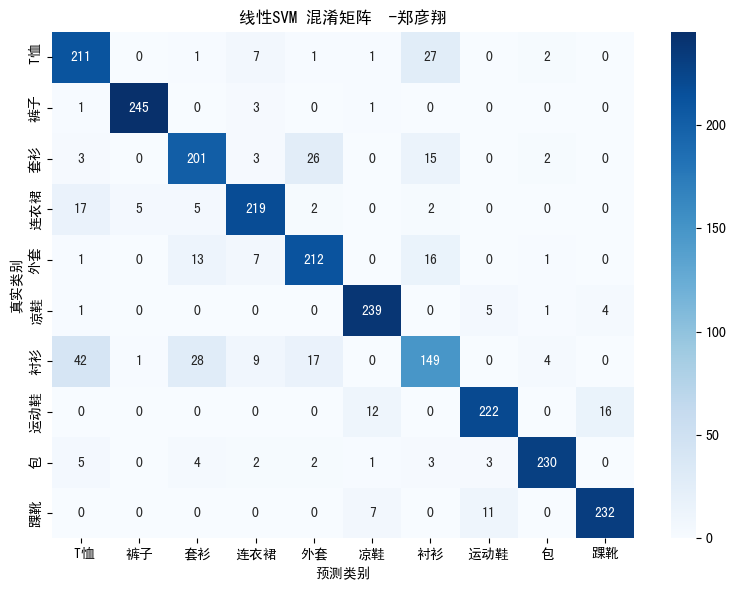

In [12]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_labels_sub, test_pred_linear)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("线性SVM 混淆矩阵  -郑彦翔")
plt.xlabel("预测类别")
plt.ylabel("真实类别")
plt.tight_layout()
plt.show()

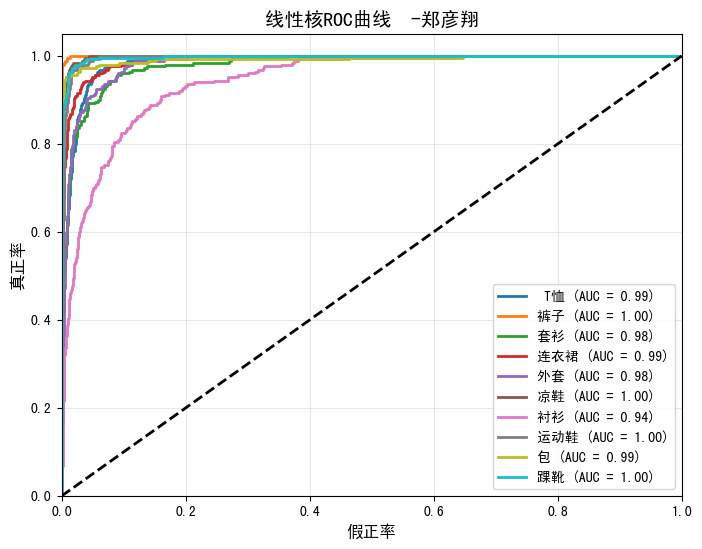

In [13]:
svm_plot_roc(best_linear,test_images_sub,test_labels_sub, '线性核ROC曲线  -郑彦翔')

### 2.$~$ 多项式核SVM
多项式核通过将原始特征映射到高维空间解决线性不可分问题，其数学表达式为：
$$K(\mathbf{x}_i, \mathbf{x}_j) = (\gamma \mathbf{x}_i^T \mathbf{x}_j + r)^d$$

- $\gamma$（缩放系数）：控制特征点积的缩放程度
- $r$（偏置项）：增加常数偏移，影响非线性程度
- $d$（多项式阶数）：决定特征组合复杂度（$d=1$时退化为线性核）


- 参数选择与影响
| 参数      | 作用                          | 推荐范围      | 风险提示                  |
|-----------|-------------------------------|---------------|---------------------------|
| `d`       | 控制决策边界复杂度            | 2-4           | $d>4$易过拟合且计算剧增 |
| $\gamma$  | 调节特征缩放强度              | 0.01-1        | 过大导致过拟合    |
| `r`       | 调整非线性程度                | 0或1          | 影响边界平滑性       |

- 但为了减少训练时间，此处我们只对`C`和`d`进行选择

In [14]:
print("\n多项式核SVM:")
poly_params = {'C': [0.1, 1], 'degree': [2, 3, 4]}
poly_svm = GridSearchCV(svm.SVC(kernel='poly', probability=True), poly_params, cv=3, scoring='accuracy', verbose=2)
poly_svm.fit(train_images_sub, train_labels_sub)
best_poly = poly_svm.best_estimator_
test_pred_poly = best_poly.predict(test_images_sub)
print("最佳参数:", poly_svm.best_params_)
print(classification_report(test_labels_sub, test_pred_poly))
results['Polynomial'] = accuracy_score(test_labels_sub, test_pred_poly)
best_models['Polynomial'] = best_poly


多项式核SVM:
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ....................................C=0.1, degree=2; total time= 1.4min
[CV] END ....................................C=0.1, degree=2; total time= 1.4min
[CV] END ....................................C=0.1, degree=2; total time= 1.5min
[CV] END ....................................C=0.1, degree=3; total time= 1.6min
[CV] END ....................................C=0.1, degree=3; total time= 1.6min
[CV] END ....................................C=0.1, degree=3; total time= 1.6min
[CV] END ....................................C=0.1, degree=4; total time= 2.0min
[CV] END ....................................C=0.1, degree=4; total time= 2.0min
[CV] END ....................................C=0.1, degree=4; total time= 2.0min
[CV] END ......................................C=1, degree=2; total time=  47.5s
[CV] END ......................................C=1, degree=2; total time=  46.0s
[CV] END ..............................

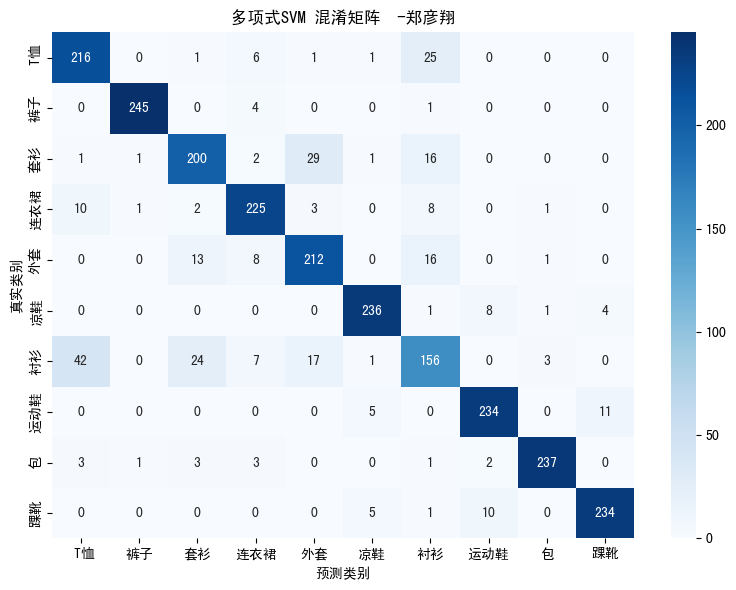

In [15]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_labels_sub, test_pred_poly)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("多项式SVM 混淆矩阵  -郑彦翔")
plt.xlabel("预测类别")
plt.ylabel("真实类别")
plt.tight_layout()
plt.show()

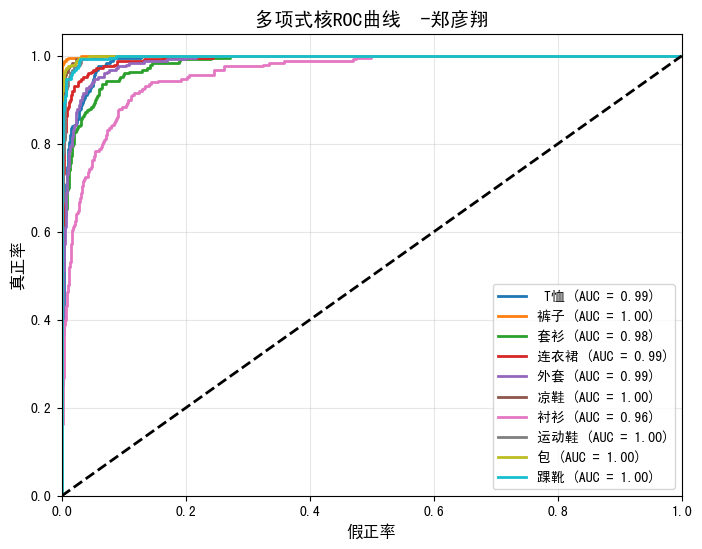

In [16]:
svm_plot_roc(best_poly,test_images_sub,test_labels_sub, '多项式核ROC曲线  -郑彦翔')

### 3.$~$ 高斯径向基核SVM 
径向基函数核是 SVM 中处理非线性分类的常用核函数，其数学表达式为：  
$$K(x_i, x_j) = e^\left(-\gamma \|x_i - x_j\|^2\right)$$  
- $\gamma$（核宽度参数）：控制高斯函数的衰减速度，决定决策边界的复杂度。  
- 核技巧本质：隐式将数据映射到无限维空间，使原始空间中线性不可分的数据在高维空间线性可分。


- 参数影响与特性
| 参数/特性      | 作用与影响                                                                 |
|----------------|--------------------------------------------------------------------------|
| **$\gamma \uparrow$** | 决策边界更复杂（过拟合风险↑），模型更关注局部样本。               |
| **$\gamma \downarrow$** | 决策边界更平滑（欠拟合风险↑），模型泛化能力增强)。                   |
| **优势**       | 通用性强，适合未知分布数据；参数少（仅需调 $\gamma$ 和 $C$)。     |
| **局限**       | 计算开销较大；需精细调参避免过拟合。                               |


In [17]:
print("\n高斯径向基核SVM:")
rbf_params = {'C': [1, 10], 'gamma': ['scale', 0.01, 0.001]}
rbf_svm = GridSearchCV(svm.SVC(kernel='rbf', probability=True), rbf_params, cv=3, scoring='accuracy', verbose=2)
rbf_svm.fit(train_images_sub, train_labels_sub)
best_rbf = rbf_svm.best_estimator_
test_pred_rbf = best_rbf.predict(test_images_sub)
print("最佳参数:", rbf_svm.best_params_)
print(classification_report(test_labels_sub, test_pred_rbf))
results['RBF'] = accuracy_score(test_labels_sub, test_pred_rbf)
best_models['RBF'] = best_rbf


高斯径向基核SVM:
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...................................C=1, gamma=scale; total time=  46.1s
[CV] END ...................................C=1, gamma=scale; total time=  45.7s
[CV] END ...................................C=1, gamma=scale; total time=  46.1s
[CV] END ....................................C=1, gamma=0.01; total time= 3.2min
[CV] END ....................................C=1, gamma=0.01; total time= 3.2min
[CV] END ....................................C=1, gamma=0.01; total time= 3.2min
[CV] END ...................................C=1, gamma=0.001; total time=  42.9s
[CV] END ...................................C=1, gamma=0.001; total time=  42.3s
[CV] END ...................................C=1, gamma=0.001; total time=  43.3s
[CV] END ..................................C=10, gamma=scale; total time=  44.4s
[CV] END ..................................C=10, gamma=scale; total time=  44.0s
[CV] END ............................

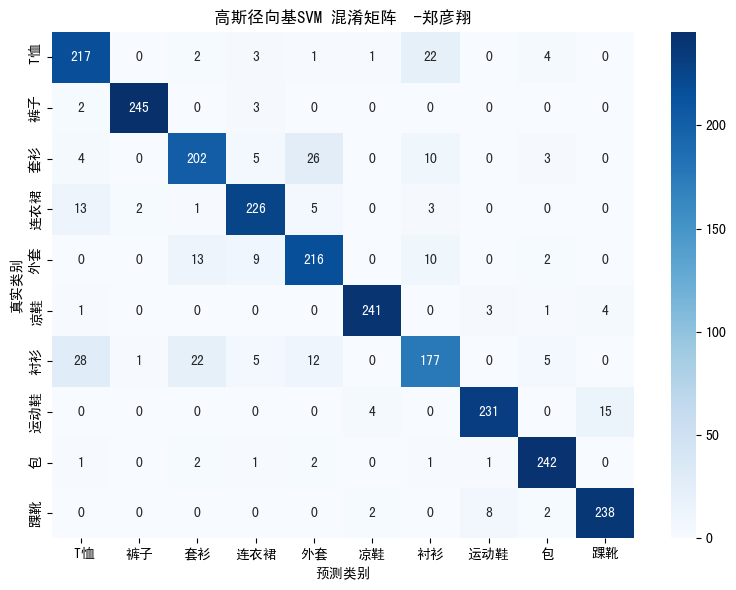

In [18]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_labels_sub, test_pred_rbf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("高斯径向基SVM 混淆矩阵  -郑彦翔")
plt.xlabel("预测类别")
plt.ylabel("真实类别")
plt.tight_layout()
plt.show()

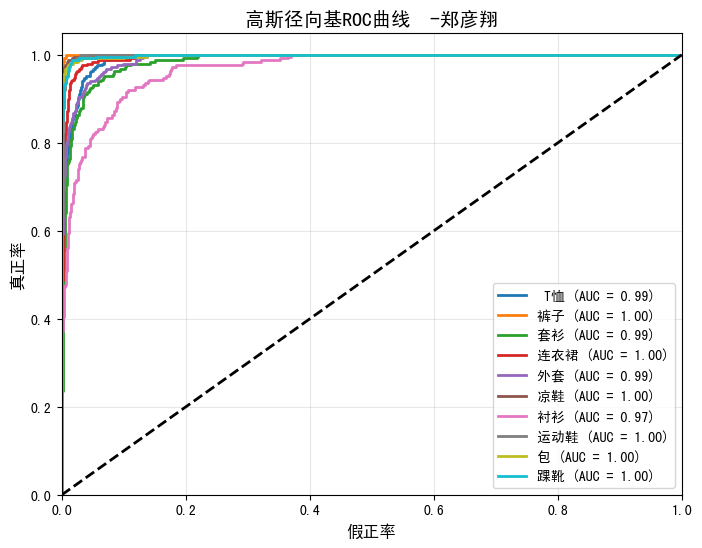

In [19]:
svm_plot_roc(best_rbf,test_images_sub,test_labels_sub, '高斯径向基ROC曲线  -郑彦翔')

- ### 比较三种不同核函数SVM的准确率
  - 计算SVM在测试集子集上的准确率
  - 绘制准确率柱状图进行比较
  - 选取核函数表现最好的SVM

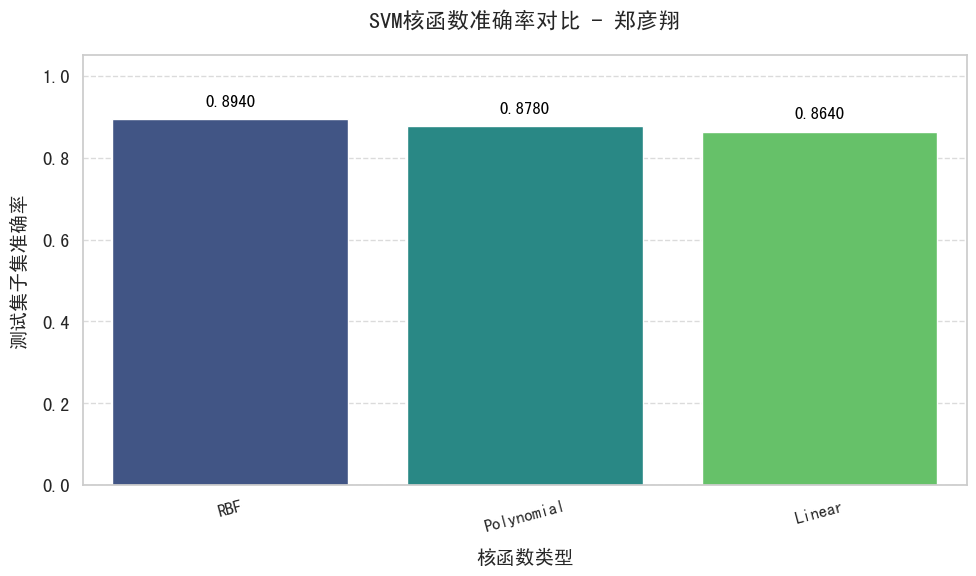


效果最好的SVM核: RBF 准确率: 0.8940


In [20]:
df_metrics = pd.DataFrame({
    '模型': list(results.keys()),
    '准确率': list(results.values())
}).sort_values(by='准确率', ascending=False)

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体支持
plt.rcParams['axes.unicode_minus'] = False    # 负号显示修正
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x='模型', 
    y='准确率', 
    data=df_metrics,
    hue='模型',
    palette='viridis',
    dodge=False,  # 避免柱状图偏移
    saturation=0.85,
    legend=False  # 避免图例重叠
)
plt.title('SVM核函数准确率对比 - 郑彦翔', fontsize=16, pad=20)
plt.xlabel('核函数类型', fontsize=14, labelpad=10)
plt.ylabel('测试集子集准确率', fontsize=14, labelpad=10)
plt.xticks(rotation=15, fontsize=12)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(
        text=f'{height:.4f}', 
        xy=(p.get_x() + p.get_width()/2, height),
        xytext=(0, 8),  # 垂直偏移
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=12,
        color='black',
        weight='bold'
    )
plt.tight_layout()
plt.show()
best_kernel = max(results, key=results.get)
print(f"\n效果最好的SVM核: {best_kernel} 准确率: {results[best_kernel]:.4f}")

## 四、采用RBF核SVM对测试集进行预测
- 使用训练好的模型作出预测
- 预测结果可视化
- 保存预测结果，方便后续对比评估

In [21]:
train_images= scaler.fit_transform(train_images)
test_images= scaler.transform(test_images)

In [22]:
test_pred_rbf = best_rbf.predict(test_images)

### 绘制预测结果的前25张图片
- 括号内为预测标签
- 绿色表示预测正确
- 红色表示预测错误

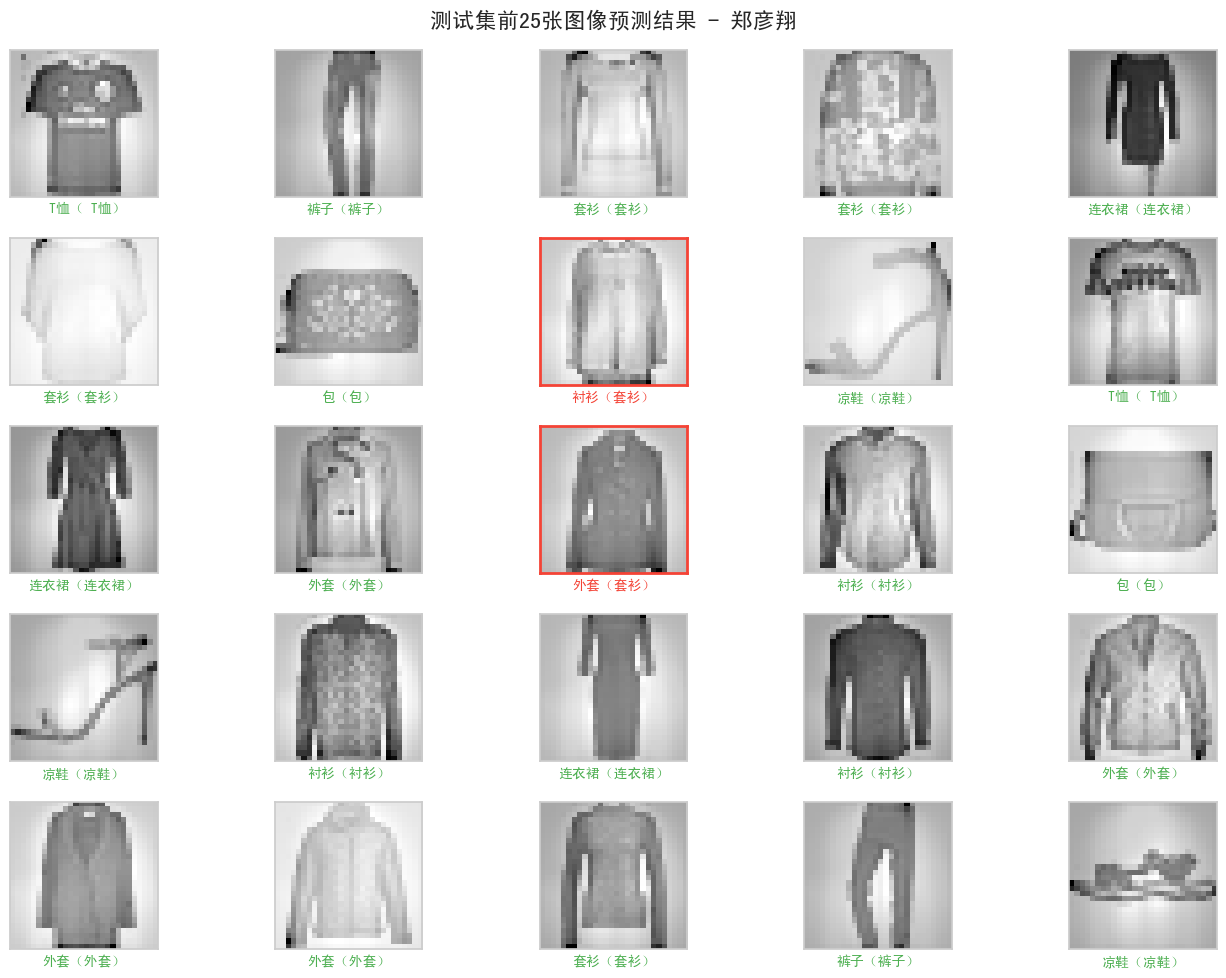

In [23]:
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体支持
plt.rcParams['axes.unicode_minus'] = False    # 负号显示修正
plt.figure(figsize=(14, 10))
plt.suptitle("测试集前25张图像预测结果 - 郑彦翔", fontsize=16, y=0.98)
test = test_images.reshape(-1,28,28)
# 获取预测结果（假设test_pred_rbf是RBF核SVM的预测结果）
predictions = test_pred_rbf[:25]  # 取前25个预测结果

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test[i], cmap=plt.cm.binary)
    
    # 获取真实标签和预测标签
    true_label = class_names[test_labels[i]]
    pred_label = class_names[predictions[i]]
    
    # 判断预测是否正确
    is_correct = (test_labels[i] == predictions[i])
    
    # 设置标签格式和颜色
    label_text = f"{true_label}（{pred_label}）"
    label_color = '#4CAF50' if is_correct else '#F44336'  # 绿色正确/红色错误
    
    # 添加文本标签[1,2](@ref)
    plt.xlabel(label_text, color=label_color, fontsize=10)
    
    # 为错误预测添加红色边框[8,9](@ref)
    if not is_correct:
        for spine in ['top', 'bottom', 'left', 'right']:
            plt.gca().spines[spine].set_color('#F44336')
            plt.gca().spines[spine].set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

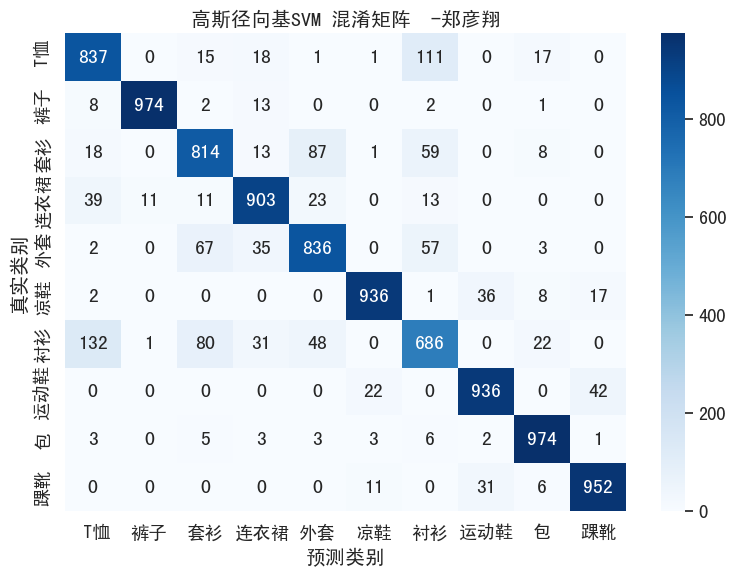

In [24]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_labels, test_pred_rbf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("高斯径向基SVM 混淆矩阵  -郑彦翔")
plt.xlabel("预测类别")
plt.ylabel("真实类别")
plt.tight_layout()
plt.show()

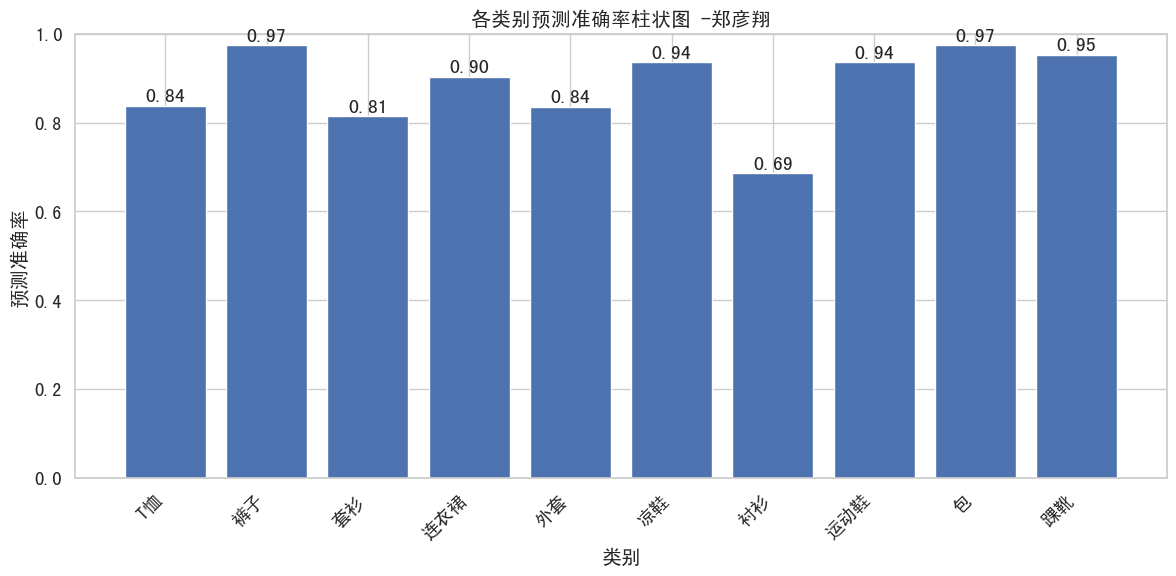

In [25]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(12, 6))
plt.bar(class_names, class_accuracy)
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1])
plt.xlabel('类别')
plt.ylabel('预测准确率')
plt.title('各类别预测准确率柱状图 -郑彦翔')

# 在柱状图上方显示准确率数值
for i, v in enumerate(class_accuracy):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

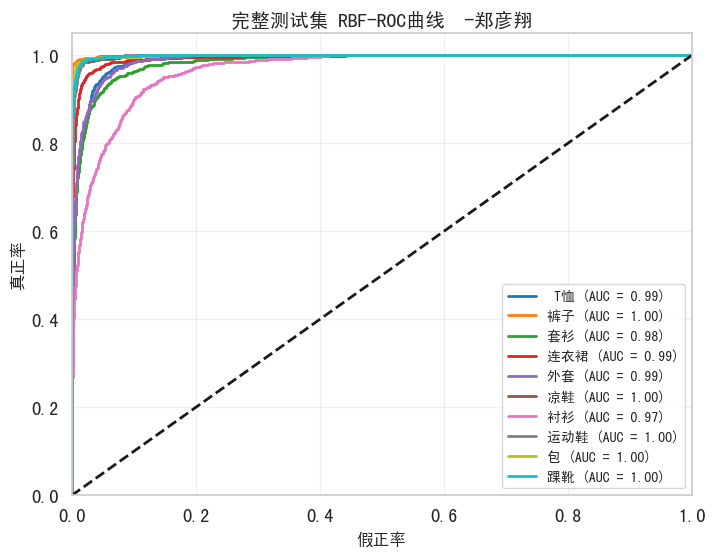

In [26]:
svm_plot_roc(best_rbf,test_images,test_labels, '完整测试集 RBF-ROC曲线  -郑彦翔')

In [27]:
evaluation_results = {
    '真实标签':test_labels,
    '预测标签':test_pred_rbf,
    '是否正确':['True' if true == pred else 'False' for true, pred in zip(test_labels, test_pred_rbf)]
}
test_df = pd.DataFrame(evaluation_results)
test_df.to_csv('./预测结果/svm_results.csv', index=False)